In [24]:
# Để cho phép phân tích mã nguồn Python
import ast

# Để quản lý dữ liệu trong dataframe
import pandas as pd

# Để vẽ các loại biểu đồ
import matplotlib.pyplot as plt

In [25]:
# Để tạo các pipeline xử lý dữ liệu và mô hình hồi quy
from sklearn.pipeline import Pipeline

# Import các mô hình hồi quy từ thư viện scikit-learn và các thư viện bổ sung
from xgboost import XGBRegressor  # XGBoost Regressor

from sklearn.svm import SVR  # Support Vector Regressor
from sklearn.tree import DecisionTreeRegressor # Decision Tree Regressor
from sklearn.ensemble import RandomForestRegressor  # Random Forest Regressor
from sklearn.ensemble import HistGradientBoostingRegressor # Histogram Gradient Boosting Regressor
from sklearn.neighbors import KNeighborsRegressor  # k-Nearest Neighbors Regressor
from sklearn.linear_model import LinearRegression  # Linear Regression

# Import các hàm và lớp cần thiết cho việc chia dữ liệu và tìm siêu tham số
from sklearn.model_selection import (KFold,
                                     train_test_split,
                                     RandomizedSearchCV)

# Import các độ đo đánh giá mô hình hồi quy
from sklearn.metrics import (mean_squared_error,
                             mean_absolute_error,
                             r2_score)

In [42]:
# Thiết lập tùy chọn hiển thị số quá dài
pd.set_option('display.float_format', lambda x: f'{x:.3e}')

# 1.&nbsp;Đọc dữ liệu

In [26]:
# Đặt đường dẫn tới tệp CSV chứa dữ liệu đã được làm sạch
dataset_path = "../data/CarPricePrediction_OneHot.csv"

# Đọc tệp CSV vào DataFrame
df = pd.read_csv(dataset_path)

In [27]:
# Hiển thị vài dòng đầu tiên của DataFrame để xem nhanh về dữ liệu
df.head()

,Năm sản xuất,Số Km đã đi,Màu sắc_be,Màu sắc_bạc,Màu sắc_cam,Màu sắc_ghi,Màu sắc_nâu,Màu sắc_trắng,Màu sắc_tím,Màu sắc_vàng,...,Xuất xứ_Nhật Bản,Xuất xứ_Nước khác,Xuất xứ_Thái Lan,Xuất xứ_Trung Quốc,Xuất xứ_Việt Nam,Xuất xứ_Đang cập nhật,Xuất xứ_Đài Loan,Xuất xứ_Đức,Xuất xứ_Ấn Độ,Giá
0,2022,50000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,559000000
1,2019,52000,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,335000000
2,2003,50000,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,106000000
3,2021,42,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,450000000
4,2022,51000,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,534000000


# 2.&nbsp;Train - Test Split

In [28]:
# Chia tập dữ liệu thành đặc trưng đầu vào và đầu ra
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# In kích thước
print(f"Kích thước X: {X.shape}")
print(f"Kích thước y: {y.shape}")

Kích thước X: (2685, 384)
Kích thước y: (2685,)


In [29]:
# Phân chia dữ liệu thành tập huấn luyện và tập kiểm thử với tỷ lệ kiểm thử là 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# In kích thước tập huấn luyện
print(f"Kích thước X_train: {X_train.shape}")
print(f"Kích thước y_train: {y_train.shape}\n")

# In kích thước tập kiểm thử
print(f"Kích thước X_test: {X_test.shape}")
print(f"Kích thước y_test: {y_test.shape}")

Kích thước X_train: (2148, 384)
Kích thước y_train: (2148,)

Kích thước X_test: (537, 384)
Kích thước y_test: (537,)


# 3.&nbsp;Lựa chọn mô hình cho dữ liệu

Dựa trên kết quả tìm được, ta có thể thấy rằng mô hình `XGBoost` cho ra giá trị của các độ đo MSE, MAE và R2 là cao nhất. Do đó, đây là mô hình tối ưu nhất cho bộ dữ liệu tìm được.

In [43]:
def create_regression_pipeline(model_name):
    """
    Tạo pipeline chỉ chứa một mô hình hồi quy cụ thể.

    Parameters:
    - model_name: str, Tên của mô hình hồi quy ('RandomForest', 'SVR', 'LinearRegression', ...).

    Returns:
    - dict, Dictionary chứa tên và pipeline đã tạo.
    """

    # Xây dựng pipeline chỉ với mô hình hồi quy
    regression_models = {
        'SVR': SVR(),
        'XGBoost': XGBRegressor(random_state=42),
        'KNeighbors': KNeighborsRegressor(),
        'DecisionTree': DecisionTreeRegressor(random_state=42),
        'RandomForest': RandomForestRegressor(random_state=42),
        'LinearRegression': LinearRegression(),
        'HistogramGradientBoosting': HistGradientBoostingRegressor(random_state=42),
    }

    # Kiểm tra xem tên mô hình có trong danh sách không
    if model_name not in regression_models:
        raise ValueError(
            f"Invalid model name. Supported models: {', '.join(regression_models.keys())}")

    # Tạo pipeline chỉ với mô hình hồi quy
    regression_pipeline = Pipeline(steps=[
        ('regressor', regression_models[model_name])
    ])

    # Tạo dictionary với key là tên pipeline và value là pipeline tương ứng
    pipeline_dict = {model_name: regression_pipeline}

    return pipeline_dict


def create_all_regression_pipelines():
    """
    Tạo tất cả các pipeline cho các mô hình hồi quy hỗ trợ.

    Returns:
    - dict, Dictionary chứa tất cả các tên và pipeline đã tạo.
    """

    # Danh sách tên các mô hình hồi quy
    regression_model_names = ['RandomForest', 'SVR', 'LinearRegression',
                              'KNeighbors', 'DecisionTree', 'XGBoost', 'HistogramGradientBoosting']

    # Dictionary để lưu trữ tất cả các pipeline
    all_pipelines = {}

    # Duyệt qua danh sách tên mô hình và tạo pipeline cho mỗi mô hình
    for model_name in regression_model_names:
        # Sử dụng hàm create_regression_pipeline để tạo pipeline cho mô hình hiện tại
        pipeline_dict = create_regression_pipeline(model_name)

        # Cập nhật vào dictionary lớn
        all_pipelines.update(pipeline_dict)

    return all_pipelines


def train_evaluate_model_with_df(model_name, model, X_train, y_train, X_test, y_test, results_df):
    """
    Huấn luyện mô hình, đánh giá hiệu suất và lưu kết quả vào DataFrame.

    Parameters:
    - model_name: str, Tên mô hình.
    - model: object, Mô hình học máy đã được khởi tạo.
    - X_train: DataFrame, Dữ liệu đào tạo.
    - y_train: Series, Nhãn của dữ liệu đào tạo.
    - X_test: DataFrame, Dữ liệu kiểm thử.
    - y_test: Series, Nhãn của dữ liệu kiểm thử.
    - results_df: DataFrame, DataFrame để lưu trữ kết quả.

    Returns:
    - DataFrame, DataFrame kết quả sau khi thêm thông tin của mô hình hiện tại.
    """

    # Huấn luyện mô hình
    model.fit(X_train, y_train)

    # Dự đoán trên dữ liệu kiểm thử
    y_pred = model.predict(X_test)

    # Đánh giá hiệu suất của mô hình
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Tạo DataFrame từ kết quả và concatenate vào DataFrame kết quả chung.
    model_results = pd.DataFrame(
        {'Mô hình': [model_name], 'MSE': mse, 'MAE': mae, 'R2': r2})
    results_df = pd.concat([results_df, model_results], ignore_index=True)

    return results_df


def run_pipelines_with_metrics_to_dataframe(all_pipelines, X_train, y_train, X_test, y_test):
    """
    Huấn luyện và đánh giá tất cả các mô hình trong danh sách pipelines và lưu kết quả vào DataFrame.

    Parameters:
    - all_pipelines: dict, Dictionary chứa tên và pipeline của các mô hình.
    - X_train: DataFrame, Dữ liệu đào tạo.
    - y_train: Series, Nhãn của dữ liệu đào tạo.
    - X_test: DataFrame, Dữ liệu kiểm thử.
    - y_test: Series, Nhãn của dữ liệu kiểm thử.

    Returns:
    - DataFrame, DataFrame chứa kết quả hiệu suất của tất cả các mô hình.
    """
    
    # Tạo DataFrame để lưu kết quả.
    results_df = pd.DataFrame(columns=['Mô hình', 'MSE', 'MAE', 'R2'])

    # Duyệt qua danh sách các mô hình và thực hiện huấn luyện và đánh giá
    for model_name, pipeline in all_pipelines.items():
        # Huấn luyện và đánh giá mô hình, sau đó lưu vào DataFrame.
        results_df = train_evaluate_model_with_df(
            model_name, pipeline, X_train, y_train, X_test, y_test, results_df)

    # Sắp xếp DataFrame theo thứ tự giảm dần của R2.
    results_df = results_df.sort_values(
        by='R2', ascending=False).reset_index(drop=True)

    return results_df

In [44]:
# Tạo tất cả các pipelines có thể có.
all_pipelines = create_all_regression_pipelines()

# Chạy các pipelines và lưu kết quả vào DataFrame.
results_df = run_pipelines_with_metrics_to_dataframe(
    all_pipelines, X_train, y_train, X_test, y_test)

# Xem kết quả đánh giá
results_df

,Mô hình,MSE,MAE,R2
0,XGBoost,6.943e+16,1.057e+08,7.765e-01
1,RandomForest,9.384e+16,1.061e+08,6.979e-01
2,DecisionTree,1.260e+17,1.241e+08,5.943e-01
3,HistogramGradientBoosting,2.052e+17,2.092e+08,3.392e-01
4,KNeighbors,3.072e+17,2.971e+08,1.100e-02
5,SVR,3.233e+17,2.909e+08,-4.093e-02
6,LinearRegression,5.337e+25,7.257e+11,-1.718e+08


# 4.&nbsp;Chạy XGBoost với tham số mặc định

In [30]:
# Tạo một XGBRegressor với các tham số mặc định
xgb_res = XGBRegressor()

# Xem các tham số mặc định
default_params = xgb_res.get_params()

# Chọn ra các tham số mà bạn quan tâm
desired_params = ['reg_lambda', 'reg_alpha', 'n_estimators', 'max_depth', 'learning_rate', 'gamma', 'colsample_bytree']

# Lọc các tham số mà bạn quan tâm từ tham số mặc định
selected_default_params = {param: default_params[param] for param in desired_params}

# Tạo DataFrame từ các tham số mà bạn quan tâm
default_params_df = pd.DataFrame([selected_default_params])

# Đảo ngược vị trí giữa tên tham số và giá trị
default_params_df = default_params_df.transpose()

# Đặt tên cột cho DataFrame
default_params_df.columns = ['Value']

# In ra DataFrame với tên tham số ở các dòng
print("Các tham số mặc định của XGBRegressor:")
default_params_df

Các tham số mặc định của XGBRegressor:


,Value
reg_lambda,None
reg_alpha,None
n_estimators,100
max_depth,None
learning_rate,None
gamma,None
colsample_bytree,None


In [31]:
# Tạo một XGBRegressor với các tham số mặc định
xgb_res = XGBRegressor()

# Huấn luyện XGBRegressor trên dữ liệu huấn luyện
# và đưa ra dự đoán trên dữ liệu kiểm thử
xgb_res.fit(X_train, y_train)
y_pred = xgb_res.predict(X_test)

# In các độ đo đánh giá mô hình
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"R-squared (R2) Score: {r2:.3f}")

Mean Squared Error (MSE): 69432493011797968.000
Mean Absolute Error (MAE): 105748676.343
R-squared (R2) Score: 0.776


# 5.&nbsp;Tuning cho XGBoost

In [32]:
# Lấy các tham số cần được điều chỉnh
params = {
    # "n_estimators": Số lần lặp của quá trình boosting.
    "n_estimators": range(100, 500, 50),

    # "learning_rate": Tỉ lệ học, giảm trọng số để làm cho quá trình boosting thêm thận trọng.
    "learning_rate": [0.0001, 0.001, 0.01, 0.1, 1],

    # "max_depth": Độ sâu tối đa của cây, ảnh hưởng đến độ phức tạp của mô hình.
    "max_depth": range(3, 21, 3),

    # "gamma": Điều chỉnh mức giảm tổn thất tối thiểu để thực hiện một phân chia.
    "gamma": [i / 10.0 for i in range(0, 5)],

    # "colsample_bytree": Phần trăm cột được lấy mẫu ngẫu nhiên cho mỗi cây.
    "colsample_bytree": [i / 10.0 for i in range(3, 10)],

    # "reg_alpha": Chế độ chính quy L1, giảm overfitting và làm mô hình thêm thận trọng.
    "reg_alpha": [1e-5, 1e-2, 0.1, 1, 10, 100],

    # "reg_lambda": Chế độ chính quy L2, giảm overfitting và làm mô hình thêm thận trọng.
    "reg_lambda": [1e-5, 1e-2, 0.1, 1, 10, 100]
}

# Tạo và huấn luyện mô hình tinh chỉnh cho XGBoost Regressor
rs = RandomizedSearchCV(XGBRegressor(),
                        params,
                        n_iter=50,
                        verbose=3,
                        random_state=42)
rs.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END colsample_bytree=0.5, gamma=0.4, learning_rate=0.0001, max_depth=12, n_estimators=250, reg_alpha=10, reg_lambda=0.1;, score=-1.019 total time=   1.1s
[CV 2/5] END colsample_bytree=0.5, gamma=0.4, learning_rate=0.0001, max_depth=12, n_estimators=250, reg_alpha=10, reg_lambda=0.1;, score=-0.352 total time=   1.1s
[CV 3/5] END colsample_bytree=0.5, gamma=0.4, learning_rate=0.0001, max_depth=12, n_estimators=250, reg_alpha=10, reg_lambda=0.1;, score=-0.788 total time=   1.3s
[CV 4/5] END colsample_bytree=0.5, gamma=0.4, learning_rate=0.0001, max_depth=12, n_estimators=250, reg_alpha=10, reg_lambda=0.1;, score=-0.637 total time=   1.1s
[CV 5/5] END colsample_bytree=0.5, gamma=0.4, learning_rate=0.0001, max_depth=12, n_estimators=250, reg_alpha=10, reg_lambda=0.1;, score=-0.988 total time=   1.0s
[CV 1/5] END colsample_bytree=0.6, gamma=0.1, learning_rate=1, max_depth=18, n_estimators=450, reg_alpha=1, reg_lambda=100;

RandomizedSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,...
                                          predictor=None, random_state=None, ...),
                   n_iter=50,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5, 0.6,
                                                             0.7, 0.8, 0.9],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.1, 1],
                                        'max_depth': range(3, 21, 3),
                                        'n_estimators': range(100, 500, 50),
                                        'reg_alpha': [1e-05, 0.01, 0.1, 1, 10,
                                                      100],
                                        'reg_lambda': [1e-05, 0.01, 0.1, 1, 10,
                                                       100]},
                   random_state=42, verbose=3)

In [33]:
# In điểm số tốt nhất và các tham số tốt nhất
# khi Random Search với các tham số trên
print(f'Điểm số tốt nhất: {rs.best_score_:.3f}')

# Tạo DataFrame từ các tham số tốt nhất
best_params_df = pd.DataFrame([rs.best_params_]).transpose()

# Đặt tên cột cho DataFrame
best_params_df.columns = ['Value']

# In ra DataFrame với tên tham số ở các dòng
print('Các tham số tốt nhất:')
best_params_df

Điểm số tốt nhất: 0.609
Các tham số tốt nhất:


,Value
reg_lambda,1.0
reg_alpha,1.0
n_estimators,450.0
max_depth,12.0
learning_rate,0.1
gamma,0.3
colsample_bytree,0.7


In [34]:
# Trích xuất thông tin kết quả Random Search và chuyển đổi thành DataFrame
results_df = pd.DataFrame(rs.cv_results_)

# Lựa chọn các cột quan trọng cho phân tích
selected_columns = ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
results_df = results_df[selected_columns]

# Sắp xếp DataFrame dựa trên rank_test_score theo thứ tự tăng dần
results_df = results_df.sort_values(by='rank_test_score')

# Lưu DataFrame đã lựa chọn vào một tệp CSV
results_df.to_csv('../tuning/RandomSearch_CV_XGBoost_OneHot.csv', index=False)

# 6.&nbsp;Đánh giá mô hình với tham số tốt nhất

## 6.1.&nbsp;Train - Test Split

In [35]:
# Lấy các tham số tốt nhất ở dòng đầu tiên của file kết quả tuning
# Sau đó, chuyển chúng thành kiểu từ điển (dictionary)
xgb_rscv = pd.read_csv("../tuning/RandomSearch_CV_XGBoost_OneHot.csv")
best_params = ast.literal_eval(xgb_rscv['params'][0])

# Tạo một XGBRegressor với các tham số tốt nhất
xgb_best = XGBRegressor(**best_params)

# Huấn luyện XGBRegressor trên dữ liệu huấn luyện
# và đưa ra dự đoán trên dữ liệu kiểm thử
xgb_best.fit(X_train, y_train)
y_pred = xgb_best.predict(X_test)

# In các độ đo đánh giá mô hình
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"R-squared (R2) Score: {r2:.3f}")

Mean Squared Error (MSE): 68625505516110360.000
Mean Absolute Error (MAE): 95715727.080
R-squared (R2) Score: 0.779


## 6.2.&nbsp;Cross Validation (K-Fold)

In [36]:
# Sử dụng KFold với 10 folds và hoán đổi dữ liệu trước mỗi lần chia
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Danh sách để lưu các giá trị MSE, MAE và R2 cho từng fold
mses = []
maes = []
r2s = []

# Vòng lặp qua các fold
for i, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Fold {i + 1}:")  # Đánh số fold từ 1 để hiển thị

    # Huấn luyện mô hình trên tập huấn luyện của fold hiện tại
    xgb_best.fit(X[train_index], y[train_index])

    # Dự đoán trên tập kiểm tra của fold hiện tại
    y_pred = xgb_best.predict(X[test_index])

    # Tính toán các độ đo
    mse = mean_squared_error(y[test_index], y_pred)
    mae = mean_absolute_error(y[test_index], y_pred)
    r2 = r2_score(y[test_index], y_pred)

    # In các độ đo cho fold hiện tại
    print(f"Mean Squared Error (MSE): {mse:.3f}")
    print(f"Mean Absolute Error (MAE): {mae:.3f}")
    print(f"R-squared (R2) Score: {r2:.3f}")

    print()  # Xuống dòng cho phần in thông tin của fold tiếp theo

    # Lưu các độ đo vào danh sách
    mses.append(mse)
    maes.append(mae)
    r2s.append(r2)

# Tính toán và in ra giá trị trung bình của các độ đo trên tất cả các fold
mean_mse = sum(mses) / len(mses)
mean_mae = sum(maes) / len(maes)
mean_r2 = sum(r2s) / len(r2s)

print(f"Mean MSEs: {mean_mse:.3f}")
print(f"Mean MAEs: {mean_mae:.3f}")
print(f"Mean R2s: {mean_r2:.3f}")

Fold 1:
Mean Squared Error (MSE): 103618951999246688.000
Mean Absolute Error (MAE): 106601901.234
R-squared (R2) Score: 0.727

Fold 2:
Mean Squared Error (MSE): 51153141871558472.000
Mean Absolute Error (MAE): 97235243.989
R-squared (R2) Score: 0.788

Fold 3:
Mean Squared Error (MSE): 59371334285279872.000
Mean Absolute Error (MAE): 105757263.896
R-squared (R2) Score: 0.847

Fold 4:
Mean Squared Error (MSE): 240210486751215168.000
Mean Absolute Error (MAE): 105412596.684
R-squared (R2) Score: 0.690

Fold 5:
Mean Squared Error (MSE): 639068111592980224.000
Mean Absolute Error (MAE): 127564470.156
R-squared (R2) Score: 0.420

Fold 6:
Mean Squared Error (MSE): 43320785216143240.000
Mean Absolute Error (MAE): 89412707.526
R-squared (R2) Score: 0.842

Fold 7:
Mean Squared Error (MSE): 96392635362123728.000
Mean Absolute Error (MAE): 97321167.687
R-squared (R2) Score: 0.809

Fold 8:
Mean Squared Error (MSE): 143963486145604432.000
Mean Absolute Error (MAE): 131040511.724
R-squared (R2) Score

## 6.3.&nbsp;Visualization

In [37]:
def plot_metric_scores(metric_values, metric_name):
    """
    Vẽ biểu đồ cột cho các giá trị của một độ đo cụ thể.

    Parameters:
    - metric_values: Danh sách chứa giá trị của độ đo cho từng fold.
    - metric_name: Tên của độ đo (vd: 'MAE', 'MSE', 'R2').

    Returns:
    None.
    """
    
    # Tạo biểu đồ cột với metric_values
    plt.figure(figsize=(8, 6))
    plt.bar(range(1, len(metric_values) + 1), metric_values, color='skyblue')
    
    # Đặt nhãn cho trục x và y
    plt.xlabel('Fold')
    plt.ylabel(f'Điểm {metric_name}')
    
    # Đặt tiêu đề cho biểu đồ
    plt.title(f'Điểm {metric_name} cho từng Fold')
    
    # Đặt các nhãn trục x là số fold
    plt.xticks(range(1, len(metric_values) + 1))
    
    # Hiển thị biểu đồ
    plt.show()

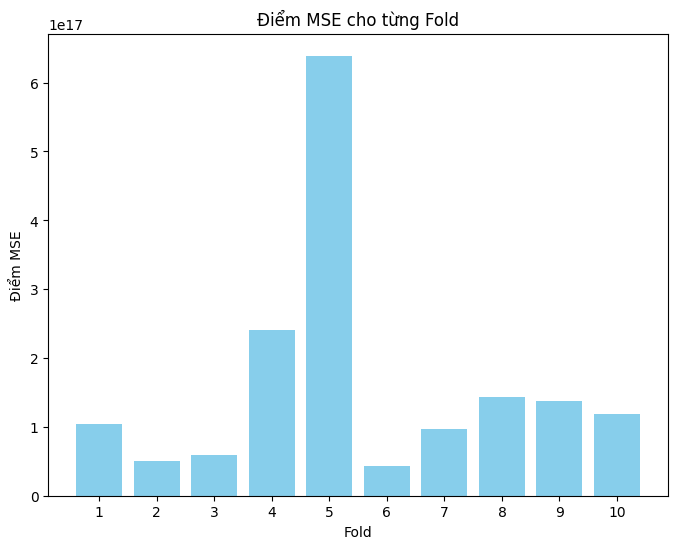

In [38]:
# Vẽ biểu đồ cho các giá trị MSE
plot_metric_scores(mses, "MSE")

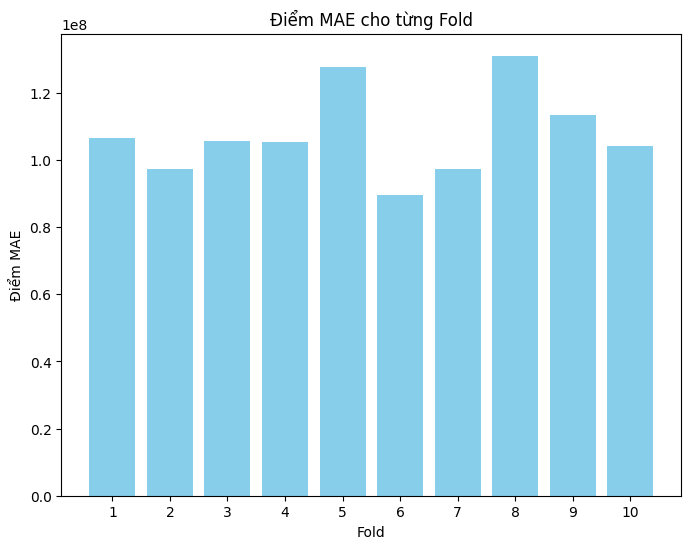

In [39]:
# Vẽ biểu đồ cho các giá trị MAE
plot_metric_scores(maes, "MAE")

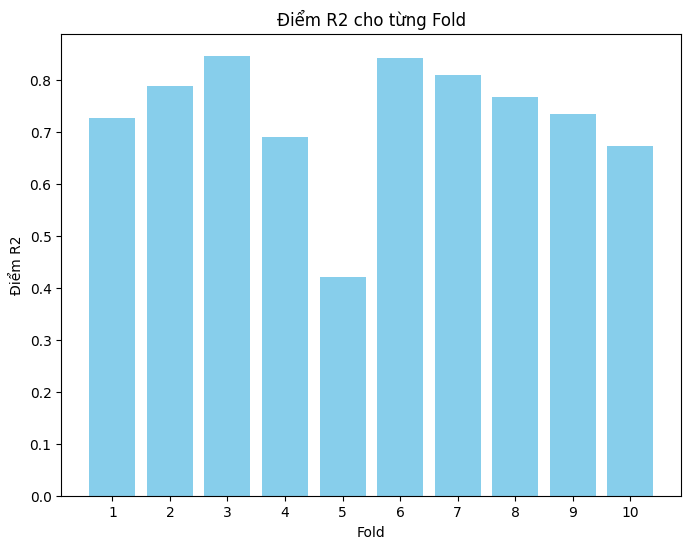

In [40]:
# Vẽ biểu đồ cho các giá trị R2
plot_metric_scores(r2s, "R2")

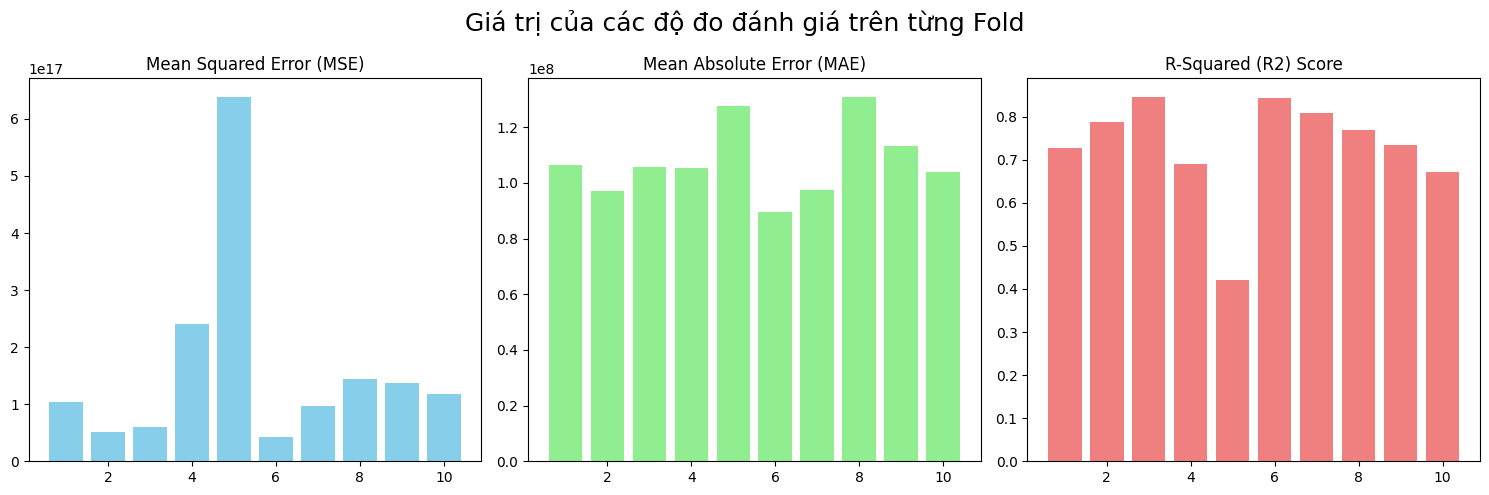

In [41]:
# Tạo figure và axes
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Biểu đồ cho MSE
axes[0].bar(range(1, len(mses) + 1), mses, color='skyblue')
axes[0].set_title('Mean Squared Error (MSE)')

# Biểu đồ cho MAE
axes[1].bar(range(1, len(maes) + 1), maes, color='lightgreen')
axes[1].set_title('Mean Absolute Error (MAE)')

# Biểu đồ cho R2
axes[2].bar(range(1, len(r2s) + 1), r2s, color='lightcoral')
axes[2].set_title('R-Squared (R2) Score')

# Tiêu đề chung cho cả 3 biểu đồ
fig.suptitle("Giá trị của các độ đo đánh giá trên từng Fold", fontsize=18)

# Hiển thị 3 biểu đồ cột trên cùng một hàng
plt.tight_layout()
plt.show()

In [ ]:
#Lưu model vào file .pkl
import joblib
best_model_filename = './best_model.pkl'
joblib.dump(xgb_best,best_model_filename)